# Grandes Etapes du parcours client

## Première modélisation densité d'évenements en alignant la date de dernier achat

Maintenant essayons de calculer les densités d'évenements par rapport au moment de l'achat:

On importe le dataframe density_data grace au script model_density.py

In [1]:
%run ../src/model_density.py

Pour calculer la densité on prend donc que les valeures avant le dernier achat de chaque acheteur.

On calcule donc la difference entre timestamp et last_purchase_timestamp pour cacluler la densité : timestamp_difference

Comme on va faire quelques graphiques, on importe matplotlib avec un style à la ggplot de R.

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from matplotlib import cm
from numpy import linspace

colors = [ cm.jet(x) for x in linspace(0.0,1.0, density_difference["event"].unique().size) ]

Pour ce faire on crée un graphique par type d'evenements qu'on va stacker pour pouvoir les comparer entre eux.

On commence par de simples histogrammes.

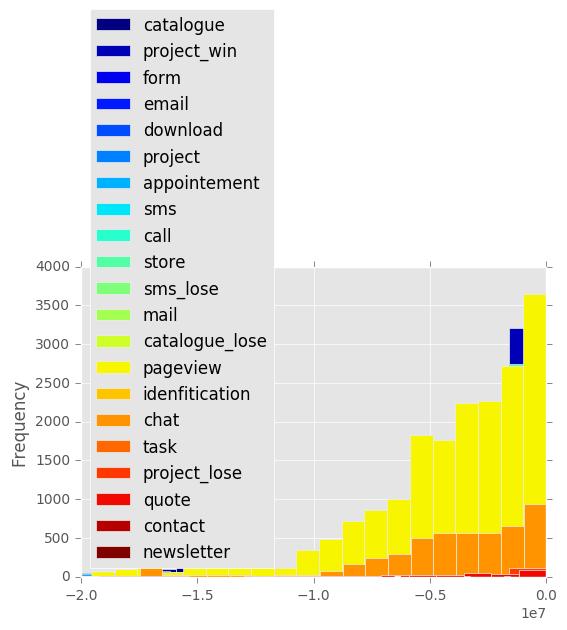

In [4]:
for i,event in enumerate(density_difference["event"].unique()):
    density_difference["timestamp_difference"][density_difference["event"]==event].plot(kind='hist',stacked=True,bins=20,label=event,legend='reverse',color=colors[i]).set_xlim(-20000000,0)
plt.show()

Résultats avec des densités

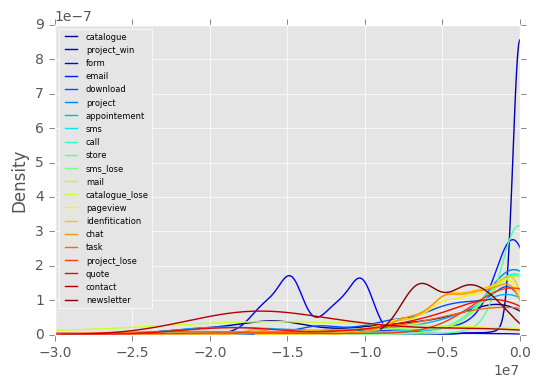

In [5]:
for i,event in enumerate(density_difference["event"].unique()):
    (density_difference["timestamp_difference"][density_difference["event"]==event]).plot(kind="density",use_index=False,legend='reverse',label=event,c=colors[i]).set_xlim(-30000000,0)

plt.legend(loc=2,prop={'size':6})
plt.show()

Le problème de ce modèle est que si les comportements proche de l'achat final sont bien retranscrits, les premiers évènements de l'acheteur ne le sont pas.
Par exemple il est impossible d'observer une tendance liée à un premier contact avec la marque.

## Deuxième modélisation densité d'évenements en alignant la date de dernier achat et de premier achat

Dans ce modèle ci l'axe du temps ira de 0 à 1, 0 étant la date de premier contact avec la marque et 1 son achat final.

Commencons par modéliser ces densités par évenements.

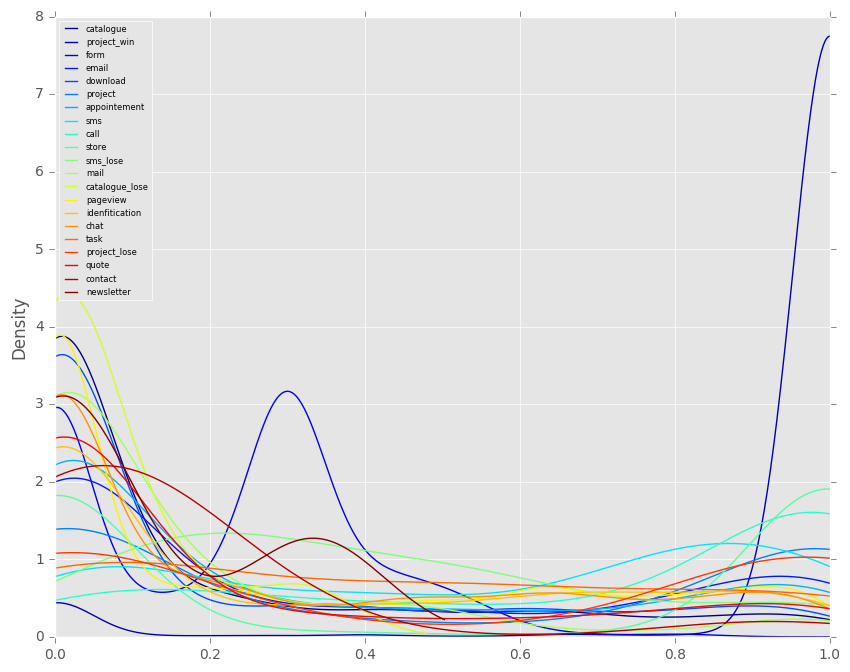

In [6]:
for i,event in enumerate(density_percentage["event"].unique()):
    (density_percentage["timestamp_percentage"][density_percentage["event"]==event]).plot(kind="density",use_index=False,legend='reverse',label=event,figsize=(10,8),c=colors[i]).set_xlim(0,1)

plt.legend(loc=2,prop={'size':6})
plt.show()

Voici ce que cela donne en construisant la densité non paramétrique pour tous les évenements.

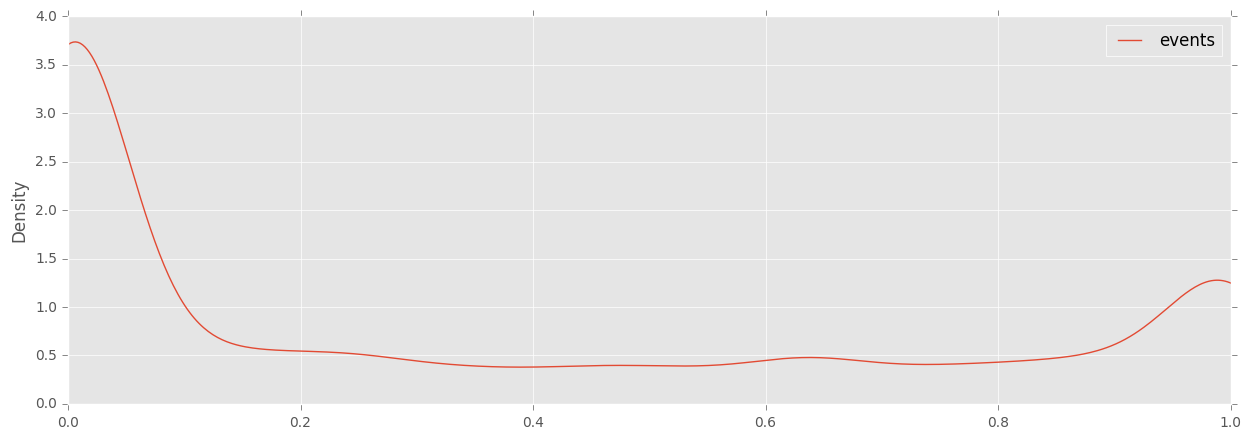

In [8]:
(density_percentage["timestamp_percentage"]).plot(kind="density",use_index=False,legend='reverse',label="events",figsize=(15,5)).set_xlim(0,1)
plt.show()

Et maintenant en affichat la répartition interne

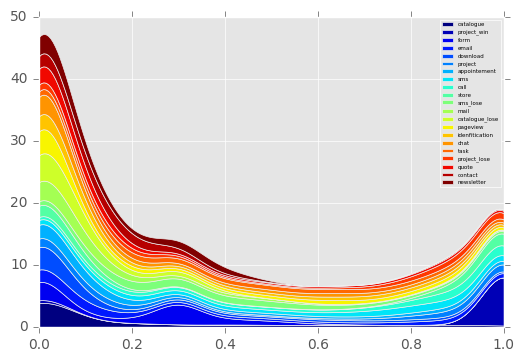

In [9]:
from scipy.stats import gaussian_kde

xs=linspace(0,1,200)
kernel=[0]*density_percentage["event"].unique().size
for i,event in enumerate(density_percentage["event"].unique()):
    kernel[i] = gaussian_kde(density_percentage["timestamp_percentage"][density_percentage["event"]==event].dropna())(xs)
plt.stackplot(xs,kernel,colors=colors)
plt.legend(density_percentage["event"].unique(),prop={'size':4})
plt.show()

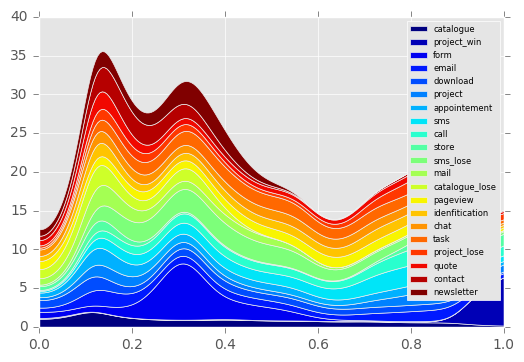

In [10]:
kernel=[0]*density_percentage["event"].unique().size
for i,event in enumerate(density_percentage["event"].unique()):
    kernel[i] = gaussian_kde(density_percentage["timestamp_percentage"][density_percentage["event"]==event].dropna())(xs)/gaussian_kde(density_percentage["timestamp_percentage"].dropna())(xs)
plt.stackplot(xs,kernel,colors=colors)
plt.legend(density_percentage["event"].unique(),prop={'size':6})
plt.show()

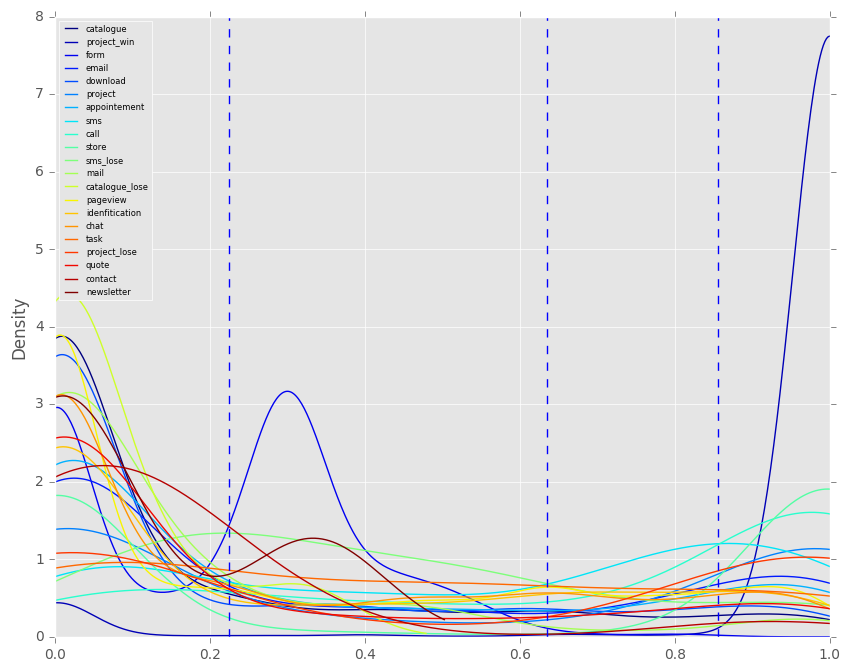

In [11]:
xs=linspace(0,1,200)
kernel=[[]*density_percentage["event"].unique().size]*xs.size
for i,event in enumerate(density_percentage["event"].unique()):
    kernel[i] = gaussian_kde(density_percentage["timestamp_percentage"][density_percentage["event"]==event].dropna())(xs)

event = [0]*xs.size
for x in range(xs.size):
    maxi=0
    for i in range(density_percentage["event"].unique().size):
        if maxi < kernel[i][x]:
            maxi = kernel[i][x]
            event[x] = density_percentage["event"].unique()[i]

test = event[0]
breaks = [0]
x = 0
limit = 0
for x in range(xs.size):
    limit +=1
    if (test != event[x]) & (limit > xs.size*0.2):
        limit = 0
        test = event[x]
        breaks.append(x)
    if (test != event[x]) & ~(limit > xs.size*0.2):
        test = event[x]
        
for i,event in enumerate(density_percentage["event"].unique()):
    (density_percentage["timestamp_percentage"][density_percentage["event"]==event]).plot(kind="density",use_index=False,legend='reverse',label=event,figsize=(10,8),c=colors[i]).set_xlim(0,1)
plt.legend(loc=2,prop={'size':6})
for b in breaks[1:len(breaks)]:
    plt.axvline(b/xs.size,linestyle="--")
    
plt.show()

In [83]:
score=[[0]*density_percentage["event"].unique().size]*(len(breaks))
breaks.append(xs.size)
for b in range(1,len(breaks)):
    for i in range(density_percentage["event"].unique().size):
        score[b-1][i]=pd.DataFrame(kernel[i][breaks[b-1]:breaks[b]]).sum()
        
#score[b-1][i]=

On supprime les traces de moins de 3 de longueur et des traces qui se passent la même journée.

Comment adapter les durées sur des non acheteurs
-> Savoir dans quelles etapes sont les non acheteurs

Determiner les pourcentages de passages entre chaques etapes